###使用tf.data加载图像

在Google Colab中运行

在GitHub上查看源代码
本教程提供了一个如何使用加载图像数据集的简单示例tf.data。

此示例中使用的数据集作为图像目录分发，每个目录有一类图像。

###建立

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/data')

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

In [5]:
tf.__version__

'1.14.0'

In [0]:
AUTOTUNE= tf.data.experimental.AUTOTUNE

##下载并检查数据集
###检索图像
在开始任何培训之前，您需要一组图像来向网络传授您想要识别的新类。您已创建了最初使用的广告素材公用许可花卉照片存档。

In [7]:
import pathlib
data_root_orig = tf.keras.utils.get_file('flower_photos',
                                        'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                        untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 3s 0us/step
/root/.keras/datasets/flower_photos


下载218MB后，您现在应该可以获得花卉照片的副本：

In [8]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/roses


In [9]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [10]:
all_image_paths[:10]

['/root/.keras/datasets/flower_photos/roses/5088766459_f81f50e57d_n.jpg',
 '/root/.keras/datasets/flower_photos/roses/3065719996_c16ecd5551.jpg',
 '/root/.keras/datasets/flower_photos/roses/8562144481_1d629848ff.jpg',
 '/root/.keras/datasets/flower_photos/tulips/5811004432_266f0f0c6f.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/9719816995_8f211abf02_n.jpg',
 '/root/.keras/datasets/flower_photos/roses/898102603_2d5152f09a.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg',
 '/root/.keras/datasets/flower_photos/tulips/13513846963_c3d5e9fb1d_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/4560663938_3557a1f831.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/4528742654_99d233223b_m.jpg']

###检查图像
现在让我们快速浏览几个图像，以便了解您正在处理的内容：

In [0]:
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [0]:
import IPython.display as display

def caption_image(image_path):
  image_rel = pathlib.Path(image_path).relative_to(data_root)
  return "Image (CC BY 2.0) " + " - ".join(attributions[str(image_rel)].split(' - ')[:-1])

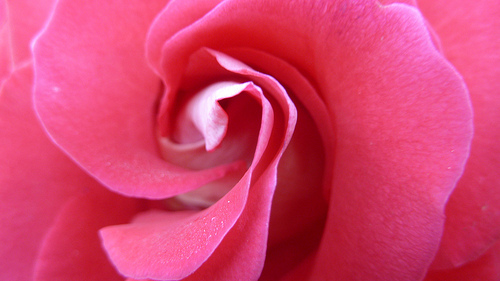

Image (CC BY 2.0)  by Cary Bass-Deschenes



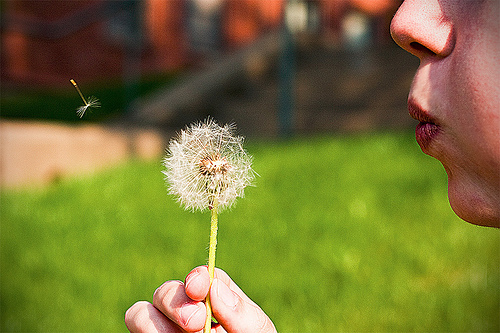

Image (CC BY 2.0)  by Joey Gannon



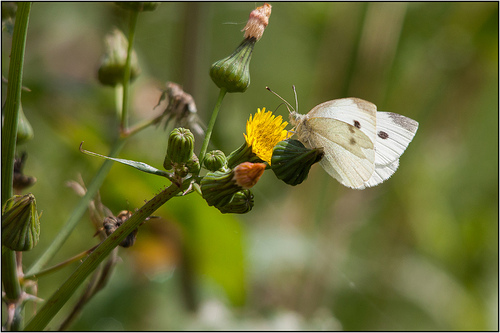

Image (CC BY 2.0)  by Tony Court



In [15]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()